# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [60]:
# Parameters
SEQ_LEN = 168  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 50 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K = 12                  # number of VMD modes (tuneable)
alpha = 1705             # VMD alpha (tuneable)
tau = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
import random
import keras
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Add, LayerNormalization
)
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint


In [62]:
save_dir = os.path.expanduser("~/Project/AtLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


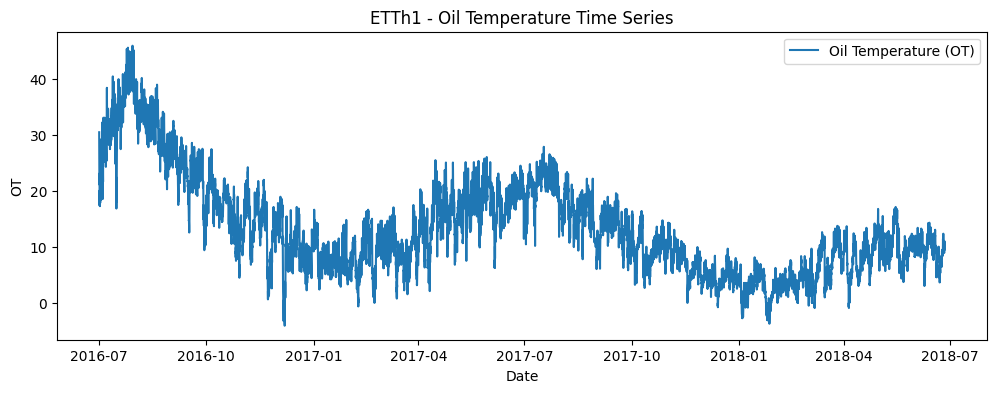

In [63]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split one feature

In [64]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    

u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

vmd_train = np.stack(u_train, axis=1)
vmd_test  = np.stack(u_test,  axis=1)

# --- Scale features & target ---
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_scaled_vmd = scaler_x.fit_transform(vmd_train)
train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
test_scaled_vmd  = scaler_x.transform(vmd_test)
test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

# --- Sequence generation (aligned) ---
X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)

## CUSTOM LAYERS

In [65]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    mode="min",
    patience=50,
    restore_best_weights=True,
    verbose=1
)
# --------------------------------------------------------
# BestEpochLogger
# --------------------------------------------------------
class BestEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, monitor="val_mae", mode="min"):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.best_epoch = None
        self.best_value = None

        if mode == "min":
            self.monitor_op = lambda a, b: a < b
            self.best_value = float("inf")
        else:
            self.monitor_op = lambda a, b: a > b
            self.best_value = -float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if self.monitor_op(current, self.best_value):
            self.best_value = current
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        if self.best_epoch is not None:
            print(
                f"\n✅ Best weights restored from epoch "
                f"{self.best_epoch + 1} "
                f"({self.monitor} = {self.best_value:.6f})"
            )
best_epoch_logger = BestEpochLogger(monitor="val_mae", mode="min")


In [66]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(
        self,
        model_dim,
        num_heads=1,
        nb_features=None,
        causal=True,
        dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.nb_features = nb_features or self.head_dim
        self.causal = causal
        self.dropout = Dropout(dropout)

        assert model_dim % num_heads == 0

    def build(self, input_shape):
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)

        # Orthogonal random features (FAVOR+)
        self.proj = self.add_weight(
            shape=(self.nb_features, self.head_dim),
            initializer="orthogonal",
            trainable=False,
            name="orthogonal_random_features"
        )

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B,H,T,Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def kernel(self, x):
        # FAVOR+ softmax kernel
        x_proj = tf.einsum("bhnd,fd->bhnf", x, self.proj)
        norm = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True) / 2.0
        return tf.exp(x_proj - norm)

    def call(self, x, training=False):
        # Self-attention for forecasting
        Q = self.split_heads(self.Wq(x))
        K = self.split_heads(self.Wk(x))
        V = self.split_heads(self.Wv(x))

        Q_phi = self.kernel(Q)
        K_phi = self.kernel(K)

        if self.causal:
            KV = tf.cumsum(
                tf.einsum("bhnf,bhne->bhnfe", K_phi, V),
                axis=2
            )
            Z = 1.0 / (
                tf.einsum(
                    "bhnf,bhnf->bhn",
                    Q_phi,
                    tf.cumsum(K_phi, axis=2)
                ) + 1e-6
            )
            out = tf.einsum("bhnf,bhnfe,bhn->bhne", Q_phi, KV, Z)
        else:
            KV = tf.einsum("bhnf,bhne->bhfe", K_phi, V)
            Z = 1.0 / (
                tf.einsum(
                    "bhnf,bhf->bhn",
                    Q_phi,
                    tf.reduce_sum(K_phi, axis=2)
                ) + 1e-6
            )
            out = tf.einsum("bhnf,bhfe,bhn->bhne", Q_phi, KV, Z)

        out = self.merge_heads(out)
        out = self.dropout(out, training=training)
        return self.Wo(out)

def build_performer_lstm_forecaster(
    input_shape,
    lstm_units=64,
    model_dim=64,
    num_heads=1,
    dense_units=64
):
    inputs = Input(shape=input_shape)

    # ===== LSTM Encoder =====
    x = LSTM(
        lstm_units,
        return_sequences=True,
        name="lstm_encoder"
    )(inputs)

    x = Dense(model_dim)(x)

    # ===== Performer Attention =====
    att_out = PerformerAttention(
        model_dim=model_dim,
        num_heads=num_heads,
        causal=True,
        name="performer_attention"
    )(x)

    # Residual connection
    x = Add()([x, att_out])
    x = LayerNormalization()(x)

    # ===== Feed Forward =====
    ff = Dense(dense_units, activation="relu")(x)
    ff = Dense(model_dim)(ff)

    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # ===== Output =====
    outputs = Dense(1, name="forecast")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model

# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out




def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                             dense_units=32, num_heads=8, model_dim=128):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)
    # -------------------------
    # 1. First LSTM Encoder
    # -------------------------
    enc_out = Bidirectional(LSTM(lstm1_units, return_sequences=True))(encoder_inputs)  # (batch, seq_len, 2*lstm1_units)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  
    enc_out = LayerNormalization()(enc_out)
    # -------------------------
    # 1b. Bahdanau Attention applied to LSTM output
    # -------------------------
    bahdanau_att = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att)

    # -------------------------
    # 2. Second LSTM Decoder
    # -------------------------
    dec_out = Bidirectional(LSTM(lstm2_units, return_sequences=False))(bahdanau_att_exp)
    dec_out = LayerNormalization()(dec_out)
    dec_out = Dense(model_dim)(dec_out) 
    dec_out = LayerNormalization()(dec_out)

    # -------------------------
    # 3. TFT Multi-Head Attention
    # -------------------------    
    att_layer = TFTTemporalAttention(
        num_heads=num_heads,
        model_dim=model_dim
    )
    att_out = att_layer([enc_out, dec_out])  # encoder_out, decoder_state

    # -------------------------
    # 5. Dense Output
    # -------------------------
    x = LSTM(dense_units)(att_out)
    output = Dense(1)(x)
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model    


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 168, 132)       │        76,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 168, 132)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_13    │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,745 (948.22 KB)

 Trainable params: 242,745 (948.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0076 - mae: 0.0618 - val_loss: 0.0021 - val_mae: 0.0363
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0042 - mae: 0.0504 - val_loss: 0.0025 - val_mae: 0.0398
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0042 - mae: 0.0502 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0035 - mae: 0.0460 - val_loss: 0.0017 - val_mae: 0.0325
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0030 - mae: 0.0421 - val_loss: 0.0022 - val_mae: 0.0377
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0018 - mae: 0.0326 - val_loss: 9.1618e-04 - val_mae: 0.0235
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 9.1587e-04 - mae: 0.0230 - val_loss: 6.8522e-04 - val_mae: 0.0208
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━

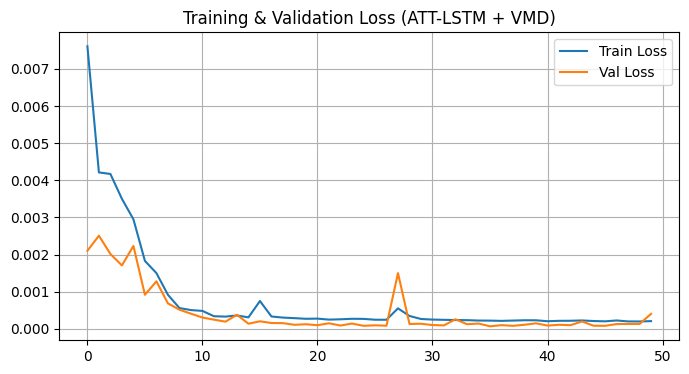

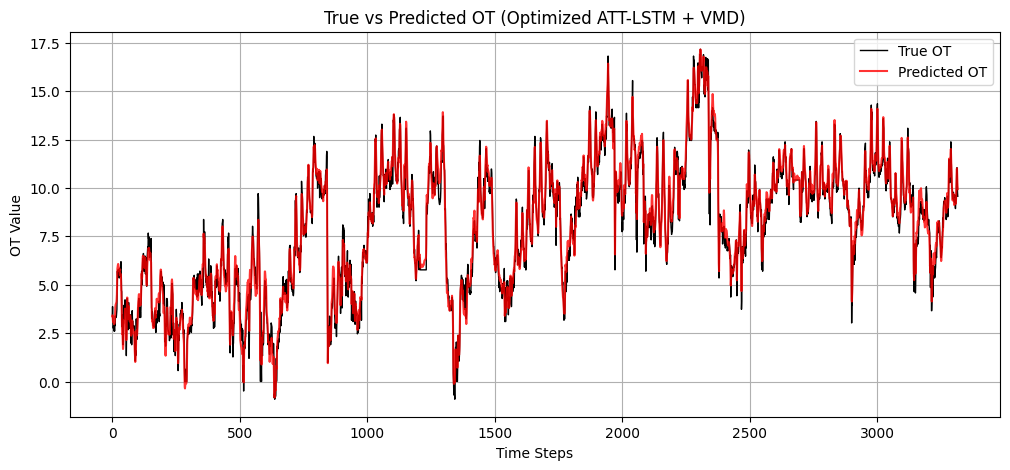

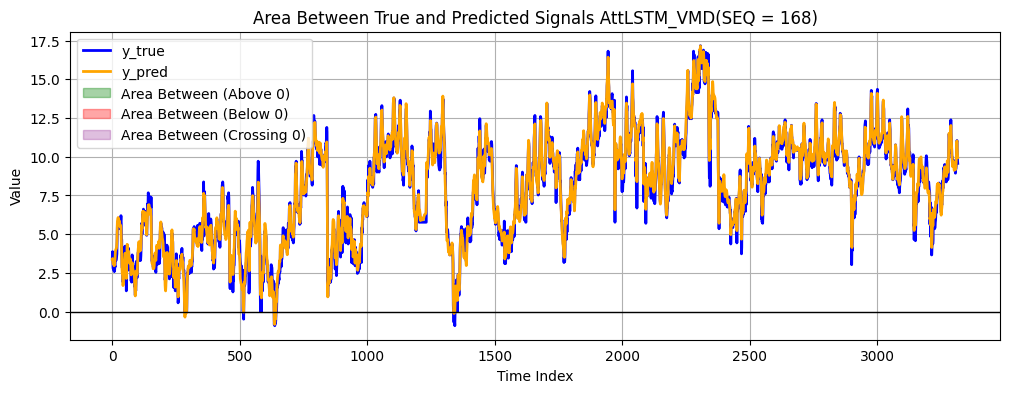

Total Area Between Curves = 1074.364218
Area Between (Above 0) = 1076.201215
Area Between (Below 0) = 326.739828
Area Between (Crossing 0) = 447.933557


/tmp/ipykernel_62403/1919628596.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/1919628596.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/1919628596.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/1919628596.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_attlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)


In [67]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

y_true = y_test_vmd_true.squeeze()
y_pred = y_pred_attlstm_vmd_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals AttLSTM_VMD(SEQ = {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_AttLSTM_VMD_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_attlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)

print(f"Total Area Between Curves = {area_total_attlstm_vmd:.6f}")
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")

# TemporalAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 168, 132)       │        76,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 168, 132)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention_3            │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,746 (948.23 KB)

 Trainable params: 242,746 (948.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0075 - mae: 0.0625 - val_loss: 0.0021 - val_mae: 0.0368
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0041 - mae: 0.0499 - val_loss: 0.0040 - val_mae: 0.0533
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0035 - mae: 0.0460 - val_loss: 0.0024 - val_mae: 0.0396
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0029 - mae: 0.0419 - val_loss: 0.0023 - val_mae: 0.0390
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0018 - mae: 0.0328 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9.7863e-04 - mae: 0.0238 - val_loss: 9.3812e-04 - val_mae: 0.0244
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0013 - mae: 0.0257 - val_loss: 9.4918e-04 - val_mae: 0.0250
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 5.4959e-04 - mae: 0.0174 - val_loss: 4.5414e-04 - val_mae: 0.0171
Epoch 9/50
431/431 ━━━━━━━━━

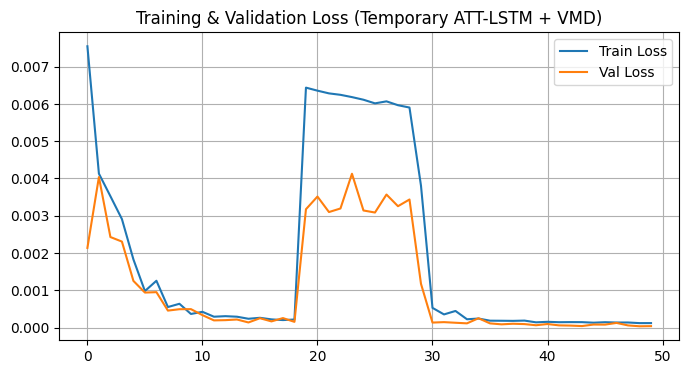

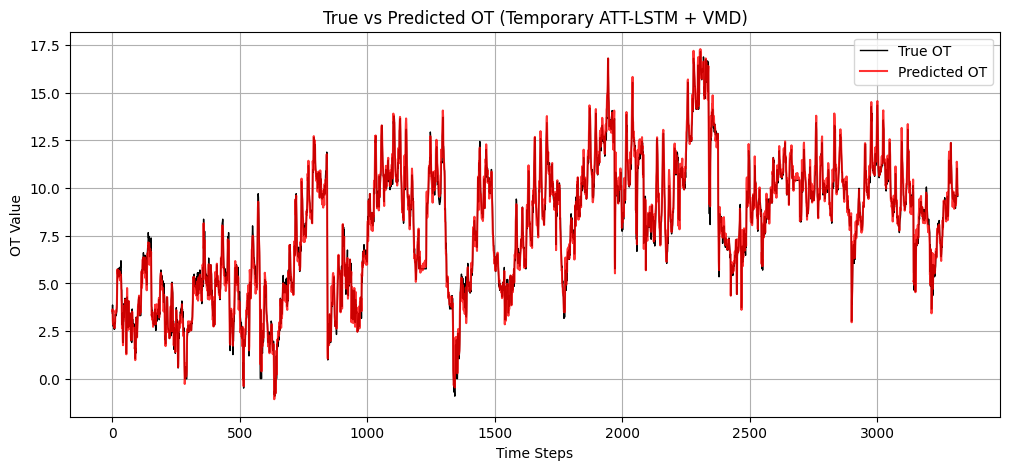

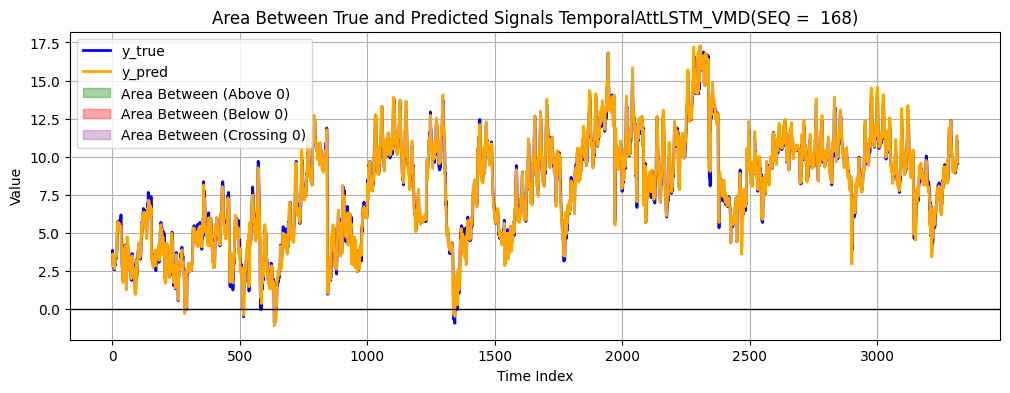

Total Area Between Curves = 743.171280
Area Between (Above 0) = 745.242652
Area Between (Below 0) = 170.901609
Area Between (Crossing 0) = 13.621483


/tmp/ipykernel_62403/1985296548.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/1985296548.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/1985296548.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/1985296548.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_Tattlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)


In [68]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)


# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

y_true = y_test_vmd_true.squeeze()
y_pred = y_pred_Tattlstm_vmd_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals TemporalAttLSTM_VMD(SEQ =  {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_TemporalAttLSTM_VMD_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_Tattlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)
print(f"Total Area Between Curves = {area_total_Tattlstm_vmd:.6f}")
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")

# TFTTMHA_BiLSTM+VMD (Temporal Fusion Transformer + Temporal Multi-Head self-Attention + Bilstm + VMD)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 168, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 168, 120)  │     35,040 │ input_layer_26[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 120)  │        240 │ bidirectional_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 168, 64)   │      7,744 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 64)   │        128 │ dense_94[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_18    │ (None, 160)       │     92,800 │ lambda_7[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 160)       │        320 │ bidirectional_18… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 64)        │     10,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_95[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ layer_normalizat… │
│ (TFTTemporalAttent… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ (None, 64)        │     33,024 │ tft_temporal_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 1)         │         65 │ lstm_56[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 200,785 (784.32 KB)

 Trainable params: 200,785 (784.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0062 - mae: 0.0502 - val_loss: 8.1112e-04 - val_mae: 0.0235
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 4.8741e-04 - mae: 0.0168 - val_loss: 2.8370e-04 - val_mae: 0.0134
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 2.5144e-04 - mae: 0.0124 - val_loss: 5.1393e-04 - val_mae: 0.0186
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 1.5864e-04 - mae: 0.0095 - val_loss: 3.7342e-04 - val_mae: 0.0163
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 1.3595e-04 - mae: 0.0091 - val_loss: 1.2245e-04 - val_mae: 0.0089
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 1.0707e-04 - mae: 0.0082 - val_loss: 1.4416e-04 - val_mae: 0.0099
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 1.1453e-04 - mae: 0.0085 - val_loss: 1.0588e-04 - val_mae: 0.0086
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 1.0351e-04 - mae: 0.0080 - val_loss: 2.2736e-0

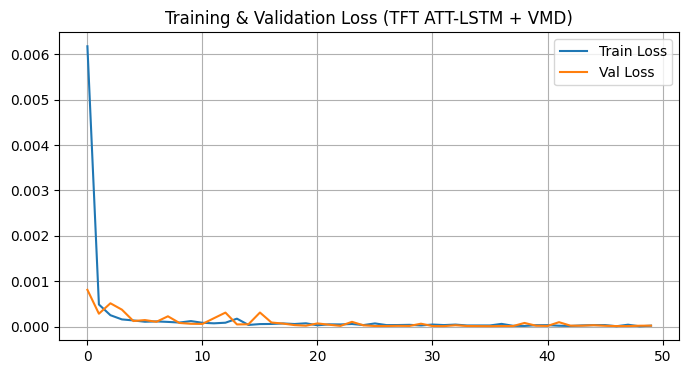

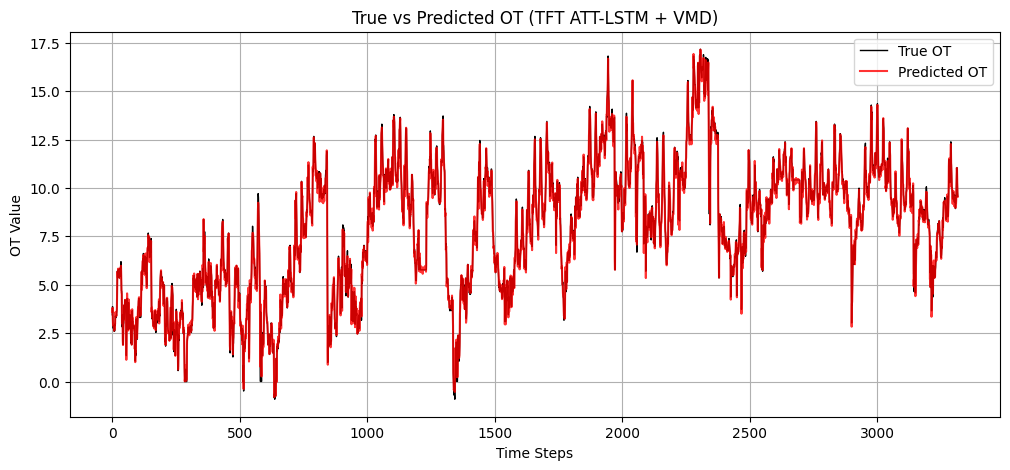

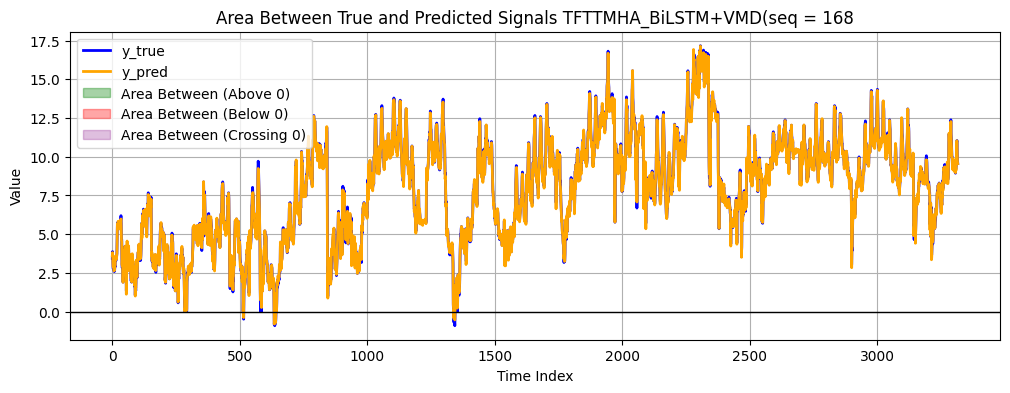

Area Between (Above 0) = 395.461275
Area Between (Below 0) = 155.089985
Area Between (Crossing 0) = 0.000000
Total Area Between Curves = 395.205761


/tmp/ipykernel_62403/3408616604.py:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/3408616604.py:99: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/3408616604.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/3408616604.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_TFTattlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)


In [69]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=60,
    lstm2_units=80,
    dense_units=64,
    num_heads=4, #### (model_dim=64) % (num_heads=24) = 16  ❌ (not zero) but #64 % 32 = 0  ✅ (remidnder is zero)
    model_dim=64
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

y_true = y_test_vmd_true.squeeze()
y_pred = y_pred_TFTattlstm_vmd_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals TFTTMHA_BiLSTM+VMD(seq = {SEQ_LEN}')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_TFTTMHA_BiLSTM_VMD_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_TFTattlstm_vmd = np.trapz(np.abs(y_true - y_pred), x)
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")
print(f"Total Area Between Curves = {area_total_TFTattlstm_vmd:.6f}")

# PerformerLSTM+VMD

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 168, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder (LSTM) │ (None, 168, 200)  │    170,400 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 168, 64)   │     12,864 │ lstm_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attention │ (None, 168, 64)   │     20,736 │ dense_101[0][0]   │
│ (PerformerAttentio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 168, 64)   │          0 │ dense_101[0][0],  │
│                     │                   │            │ performer_attent… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 168, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 168, 64)   │      4,160 │ dense_106[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 168, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_107[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forecast (Dense)    │ (None, 168, 1)    │         65 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212,641 (830.63 KB)

 Trainable params: 208,545 (814.63 KB)

 Non-trainable params: 4,096 (16.00 KB)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0927 - mae: 0.1193 - val_loss: 0.0059 - val_mae: 0.0648
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0057 - mae: 0.0573 - val_loss: 0.0025 - val_mae: 0.0398
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0057 - mae: 0.0579 - val_loss: 0.0044 - val_mae: 0.0550
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0053 - mae: 0.0558 - val_loss: 0.0100 - val_mae: 0.0885
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0055 - mae: 0.0573 - val_loss: 0.0033 - val_mae: 0.0460
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0054 - mae: 0.0569 - val_loss: 0.0025 - val_mae: 0.0397
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0052 - mae: 0.0555 - val_loss: 0.0045 - val_mae: 0.0556
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0058 - mae: 0.0591 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms

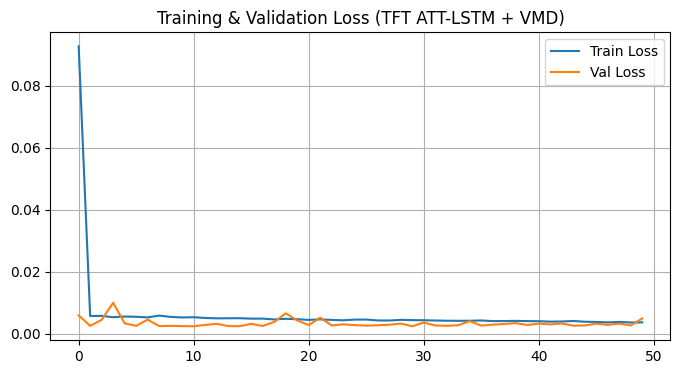

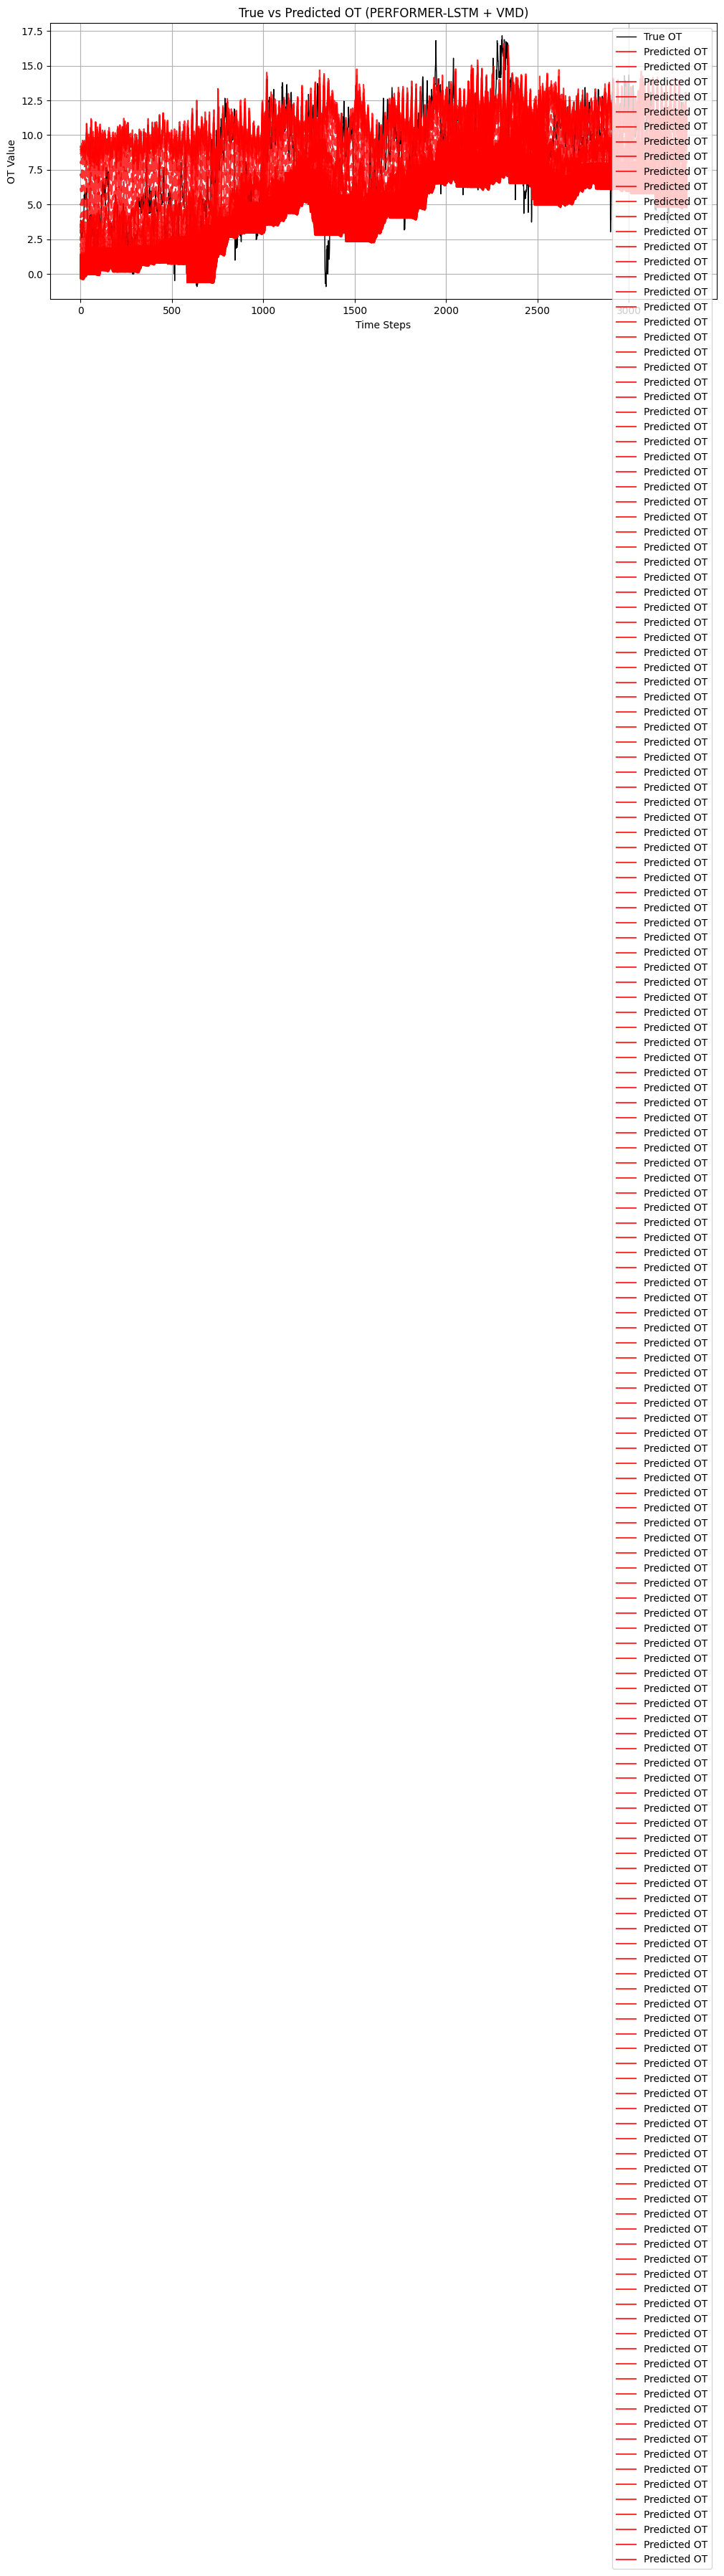

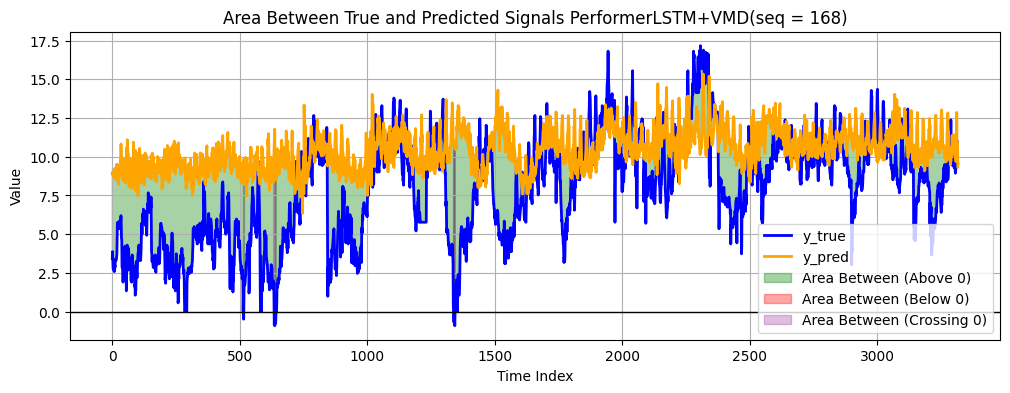

Area Between (Above 0) = 10735.744642
Area Between (Below 0) = 0.000000
Area Between (Crossing 0) = 8701.955643
Total Area Between Curves = 10750.304892


/tmp/ipykernel_62403/2469121277.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_above], x[mask_above])
/tmp/ipykernel_62403/2469121277.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_below], x[mask_below])
/tmp/ipykernel_62403/2469121277.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/2469121277.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_Performer_lstm = np.tra

In [70]:
model_performer_lstm = build_performer_lstm_forecaster(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm_units=200,
    model_dim=64,
    num_heads=1
)

model_performer_lstm.summary()

history_model_performer_lstm = model_performer_lstm.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)

# Predict and inverse-transform
y_pred_model_performer_lstm_scaled = model_performer_lstm.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_model_performer_lstm_scaled.reshape(-1, 1)
# Inverse transform
y_pred_performer_lstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)
# Optional: reshape back to (num_samples, time_steps)
y_pred_performer_lstm_vmd_true = y_pred_performer_lstm_vmd_true.reshape(y_pred_model_performer_lstm_scaled.shape[0],
                                                                y_pred_model_performer_lstm_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_model_performer_lstm.history['loss'], label='Train Loss')
plt.plot(history_model_performer_lstm.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_performer_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (PERFORMER-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

# =====================================================
# Corrected Visualization for Multi-Step Predictions
# =====================================================

# Select first prediction step
y_true_step1 = y_test_vmd_true[:, 0]   # first time step of each sample
y_pred_step1 = y_pred_performer_lstm_vmd_true[:, 0]

x = np.arange(len(y_true_step1))

plt.figure(figsize=(12,4))
plt.plot(x, y_true_step1, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred_step1, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)

# Masks for area coloring
mask_above = (y_true_step1 >= 0) & (y_pred_step1 >= 0)
mask_below = (y_true_step1 < 0) & (y_pred_step1 < 0)
mask_cross = ~(mask_above | mask_below)

# Fill areas
plt.fill_between(x, y_true_step1, y_pred_step1, where=mask_above, color='green', alpha=0.35, label='Area Between (Above 0)')
plt.fill_between(x, y_true_step1, y_pred_step1, where=mask_below, color='red', alpha=0.35, label='Area Between (Below 0)')
plt.fill_between(x, y_true_step1, y_pred_step1, where=mask_cross, color='purple', alpha=0.25, label='Area Between (Crossing 0)')

plt.title(f'Area Between True and Predicted Signals PerformerLSTM+VMD(seq = {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Save figure
plt.savefig(f'area_between_signals_PerformerLSTM_VMD_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute areas
area_above = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true_step1 - y_pred_step1)[mask_cross], x[mask_cross])
area_total_Performer_lstm = np.trapz(np.abs(y_true_step1 - y_pred_step1), x)

print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")
print(f"Total Area Between Curves = {area_total_Performer_lstm:.6f}")

# AttLSTM

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 168, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 168, 122)       │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 168, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_15    │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0078 - mae: 0.0618 - val_loss: 0.0030 - val_mae: 0.0434
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0046 - mae: 0.0524 - val_loss: 0.0034 - val_mae: 0.0459
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0044 - mae: 0.0513 - val_loss: 0.0027 - val_mae: 0.0417
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0043 - mae: 0.0510 - val_loss: 0.0027 - val_mae: 0.0419
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0042 - mae: 0.0500 - val_loss: 0.0026 - val_mae: 0.0410
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0039 - mae: 0.0484 - val_loss: 0.0028 - val_mae: 0.0428
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0037 - mae: 0.0471 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0034 - mae: 0.0449 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/

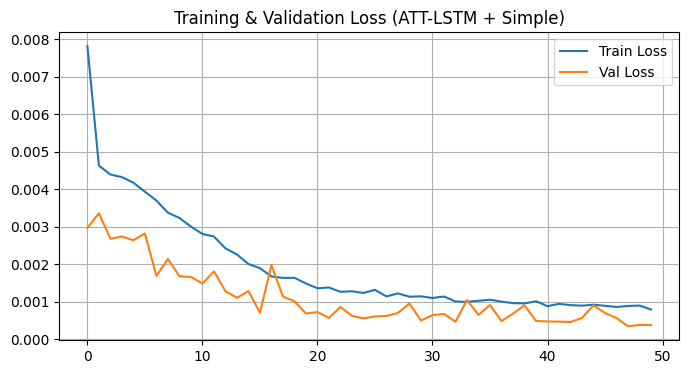

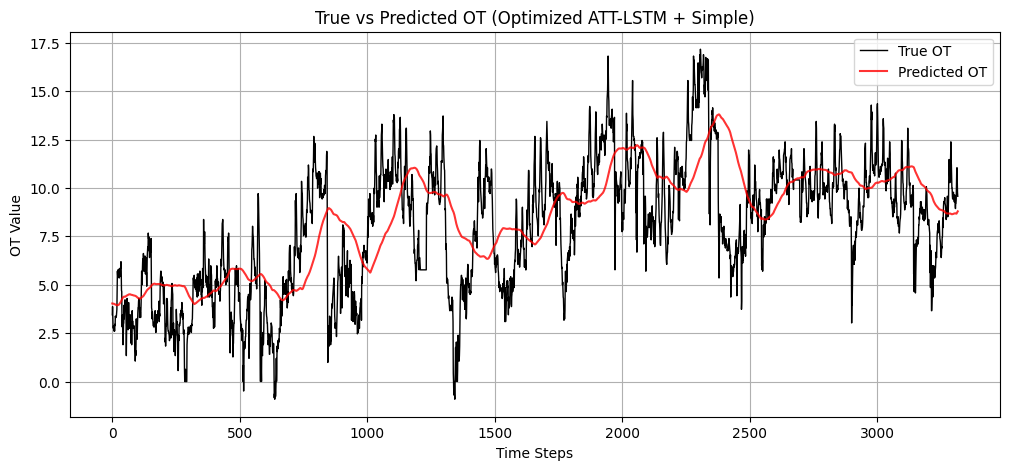

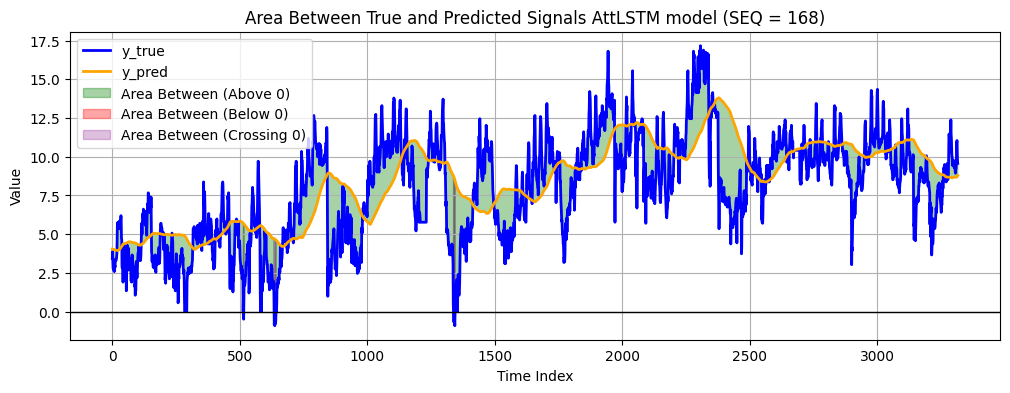

Total Area Between Curves = 7200.750733
Area Between (Above 0) = 7191.062903
Area Between (Below 0) = 0.000000
Area Between (Crossing 0) = 5842.908602


/tmp/ipykernel_62403/3389596823.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/3389596823.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/3389596823.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/3389596823.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_attlstm_simple = np.trapz(np.abs(y_true - y_pred), x)


In [71]:
model_build_attlstm_simple = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_simple.summary()

history_attlstm_simple = model_build_attlstm_simple.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_simple.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()


y_true = y_test_simple_true.squeeze()
y_pred = y_pred_attlstm_simple_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals AttLSTM model (SEQ = {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_AttLSTM_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_attlstm_simple = np.trapz(np.abs(y_true - y_pred), x)
print(f"Total Area Between Curves = {area_total_attlstm_simple:.6f}")
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")

# BidirectionalLSTM

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 168, 200)       │        90,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 168, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,901 (823.83 KB)

 Trainable params: 210,901 (823.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0032 - mae: 0.0372 - val_loss: 4.9754e-04 - val_mae: 0.0175
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 2.8980e-04 - val_mae: 0.0124
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 2.3001e-04 - val_mae: 0.0105
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 9.4354e-04 - mae: 0.0230 - val_loss: 2.1349e-04 - val_mae: 0.0102
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 8.6204e-04 - mae: 0.0217 - val_loss: 2.3050e-04 - val_mae: 0.0110
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 8.0993e-04 - mae: 0.0209 - val_loss: 5.7864e-04 - val_mae: 0.0206
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 7.3954e-04 - mae: 0.0201 - val_loss: 2.2678e-04 - val_mae: 0.0110
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 6.8866e-04 - mae: 0.0193 - val_loss: 2.4407e-04 - val_

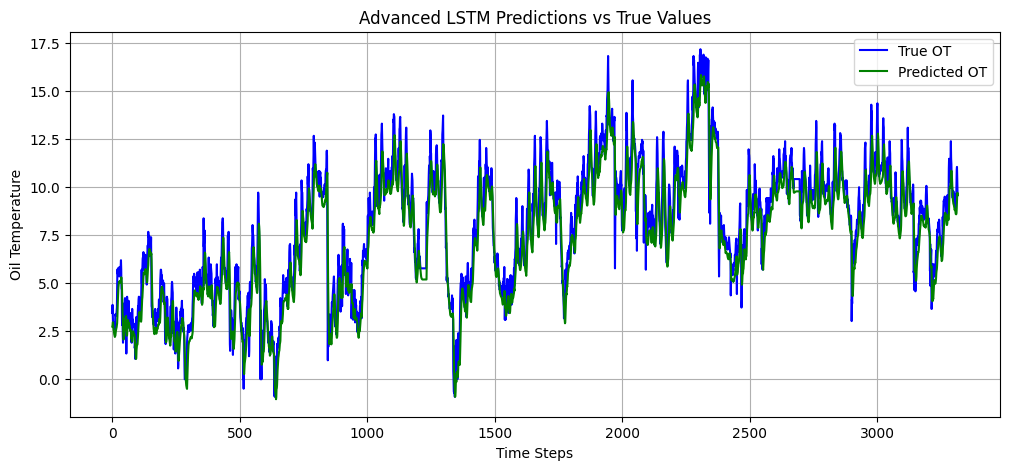

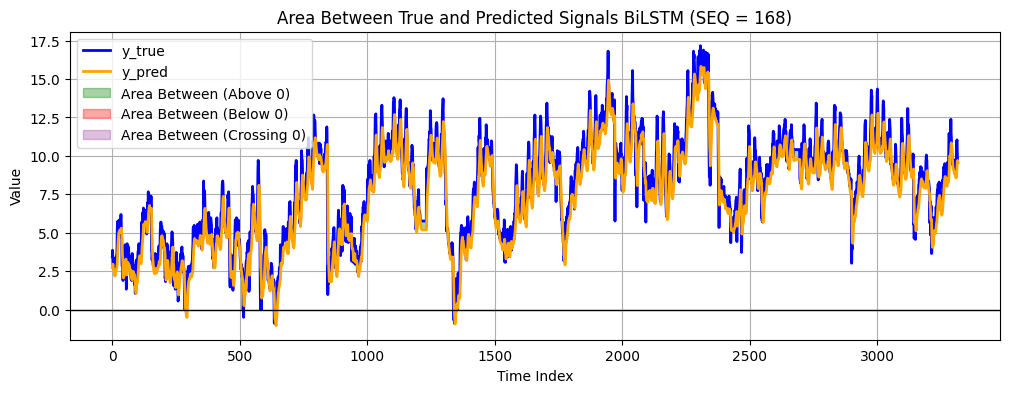

Total Area Between Curves = 2902.338450
Area Between (Above 0) = 2905.449680
Area Between (Below 0) = 257.374021
Area Between (Crossing 0) = 2046.229319


/tmp/ipykernel_62403/3392393061.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/3392393061.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/3392393061.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/3392393061.py:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_Bidirectional_lstm_simple = np.trapz(np.abs(y_true - y_pred

In [72]:
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

y_true = y_test_simple_true.squeeze()
y_pred = y_pred_Bidirectional_lstm_simple_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals BiLSTM (SEQ = {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_BiLSTM_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_Bidirectional_lstm_simple = np.trapz(np.abs(y_true - y_pred), x)
print(f"Total Area Between Curves = {area_total_Bidirectional_lstm_simple:.6f}")
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")

# LSTM

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 168, 128)       │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,905 (796.50 KB)

 Trainable params: 203,905 (796.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0038 - mae: 0.0404 - val_loss: 6.4931e-04 - val_mae: 0.0197
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 4.0523e-04 - val_mae: 0.0151
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 3.6909e-04 - val_mae: 0.0145
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 9.4878e-04 - mae: 0.0230 - val_loss: 2.6184e-04 - val_mae: 0.0117
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 8.4649e-04 - mae: 0.0216 - val_loss: 2.7129e-04 - val_mae: 0.0124
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 7.6891e-04 - mae: 0.0204 - val_loss: 1.9133e-04 - val_mae: 0.0095
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 7.0705e-04 - mae: 0.0195 - val_loss: 2.7593e-04 - val_mae: 0.0128
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 6.5320e-04 - mae: 0.0187 - val_loss: 2.9059e-04 - val_

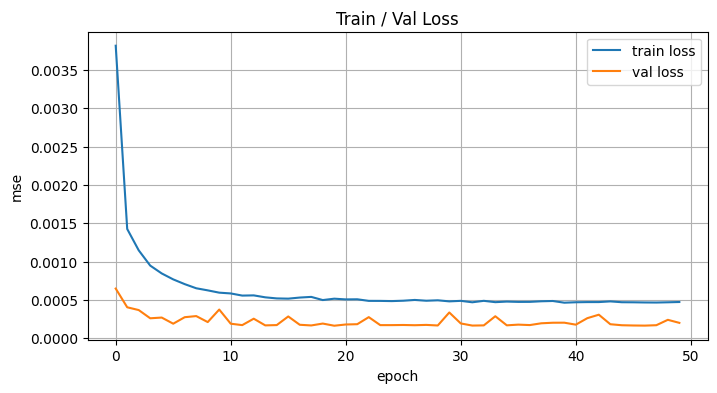

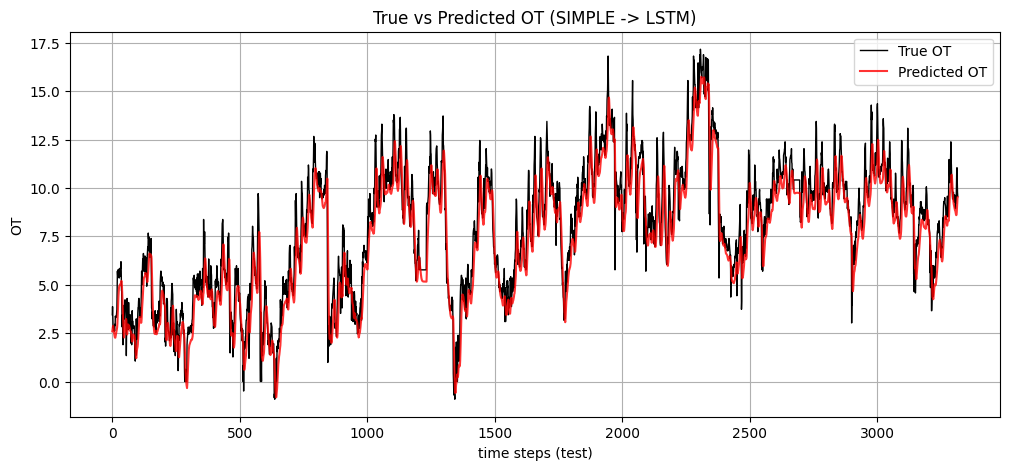

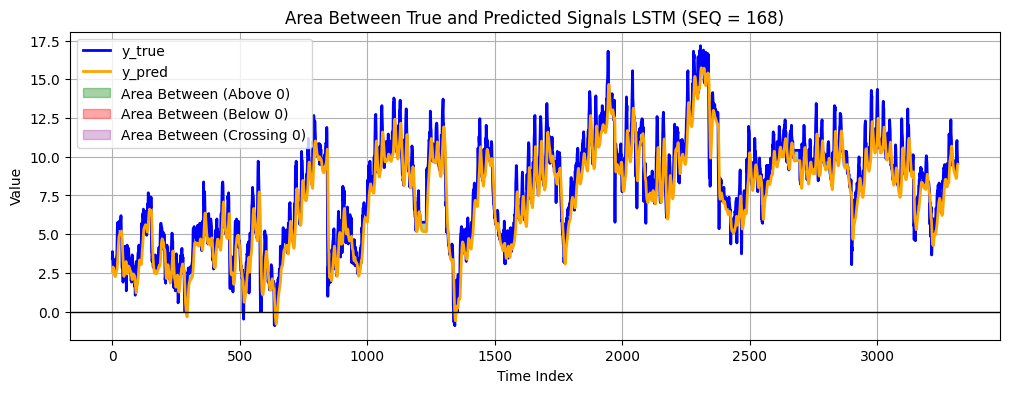

Total Area Between Curves = 3271.842070
Area Between (Above 0) = 3266.277847
Area Between (Below 0) = 321.804004
Area Between (Crossing 0) = 2245.704592


/tmp/ipykernel_62403/312705310.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
/tmp/ipykernel_62403/312705310.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
/tmp/ipykernel_62403/312705310.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
/tmp/ipykernel_62403/312705310.py:106: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_total_lstm_simple = np.trapz(np.abs(y_true - y_pred), x)


In [73]:
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, best_epoch_logger],
    verbose=1
)
# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_simple_scaled = model_lstm_model.predict(X_test_simple)
y_pred_lstm_simple_true = scaler_y.inverse_transform(y_pred_lstm_simple_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (SIMPLE -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()


y_true = y_test_simple_true.squeeze()
y_pred = y_pred_lstm_simple_true.squeeze()
x = np.arange(len(y_true))
plt.figure(figsize=(12,4))
plt.plot(x, y_true, label='y_true', color='blue', linewidth=2)
plt.plot(x, y_pred, label='y_pred', color='orange', linewidth=2)
plt.axhline(0, color='black', linewidth=1)
# 🔵 
mask_above = (y_true >= 0) & (y_pred >= 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_above,
    interpolate=True,
    color='green',
    alpha=0.35,
    label='Area Between (Above 0)'
)
# 🔴 
mask_below = (y_true < 0) & (y_pred < 0)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_below,
    interpolate=True,
    color='red',
    alpha=0.35,
    label='Area Between (Below 0)'
)
# 🟣 
mask_cross = ~(mask_above | mask_below)
plt.fill_between(
    x,
    y_true,
    y_pred,
    where=mask_cross,
    interpolate=True,
    color='purple',
    alpha=0.25,
    label='Area Between (Crossing 0)'
)
plt.title(f'Area Between True and Predicted Signals LSTM (SEQ = {SEQ_LEN})')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(f'area_between_LSTM_{SEQ_LEN}.png', dpi=300, bbox_inches='tight')
plt.show()

area_above = np.trapz(np.abs(y_true - y_pred)[mask_above], x[mask_above])
area_below = np.trapz(np.abs(y_true - y_pred)[mask_below], x[mask_below])
area_cross = np.trapz(np.abs(y_true - y_pred)[mask_cross], x[mask_cross])
area_total_lstm_simple = np.trapz(np.abs(y_true - y_pred), x)
print(f"Total Area Between Curves = {area_total_lstm_simple:.6f}")
print(f"Area Between (Above 0) = {area_above:.6f}")
print(f"Area Between (Below 0) = {area_below:.6f}")
print(f"Area Between (Crossing 0) = {area_cross:.6f}")

# Compare Models

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple, r2_Lstm_simple = compute_metrics(y_pred_lstm_simple_true, y_test_vmd_true)
#mse_Performer_lstm, rmse_Performer_lstm, mae_Performer_lstm, r2_Performer_lstm = compute_metrics(y_pred_performer_lstm_vmd_true.flatten(), y_test_vmd_true)

import pandas as pd

results = [
    ["AttLSTM + VMD", 
     mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd, area_total_attlstm_vmd],

    ["Temporal-AttLSTM + VMD", 
     mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd, area_total_Tattlstm_vmd],

    ["TFTTMHA_BiLSTM + VMD", 
     mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd, area_total_TFTattlstm_vmd],

    # ["Performer-LSTM + VMD",
    #  mse_Performer_lstm, rmse_Performer_lstm, mae_Performer_lstm, r2_Performer_lstm,area_total_Performer_lstm],   
   
    ["BiLSTM", 
     mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple,
     mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple,
     area_total_Bidirectional_lstm_simple],

    ["AttLSTM", 
     mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple,
     r2_attlstm_simple, area_total_attlstm_simple],

    ["LSTM", 
     mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple,
     r2_Lstm_simple, area_total_lstm_simple],
]

df_results = pd.DataFrame(
    results,
    columns=["Model", "MSE", "RMSE", "MAE", "R²", "Diffrential Total Area(DTA)"]
)

# Sort by MAE (primary metric)
df_results = df_results.sort_values("MAE").reset_index(drop=True)



from docx import Document
from docx.shared import Inches

# Create Word document
doc = Document()
doc.add_heading(f'Model Performance Comparison seq = {SEQ_LEN}', level=1)

# Add table
table = doc.add_table(rows=1, cols=6)
table.style = 'Table Grid'

# Header row
hdr_cells = table.rows[0].cells
headers = ["Model", "MSE", "RMSE", "MAE", "R²", "Diffrential Total Area(DTA)"]

for i, header in enumerate(headers):
    hdr_cells[i].text = header

# Add data rows
for _, row in df_results.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = row["Model"]
    row_cells[1].text = f"{row['MSE']:.4f}"
    row_cells[2].text = f"{row['RMSE']:.4f}"
    row_cells[3].text = f"{row['MAE']:.4f}"
    row_cells[4].text = f"{row['R²']:.4f}"
    row_cells[5].text = f"{row['Diffrential Total Area(DTA)']:.4f}"

# Save document
doc.save(f'Model_Performance_Comparison_{SEQ_LEN}.docx')
df_results


,Model,MSE,RMSE,MAE,R²,Diffrential Total Area(DTA)
0,TFTTMHA_BiLSTM + VMD,0.023724,0.154025,0.119208,0.997837,395.205761
1,Temporal-AttLSTM + VMD,0.083402,0.288794,0.224147,0.992802,743.171280
2,AttLSTM + VMD,0.171421,0.414030,0.324062,0.984881,1074.364218
3,BiLSTM,1.248180,1.117220,0.875362,0.881573,2902.338450
4,LSTM,1.628917,1.276290,0.986821,0.843233,3271.842070
5,AttLSTM,7.451020,2.729656,2.171722,-0.170329,7200.750733


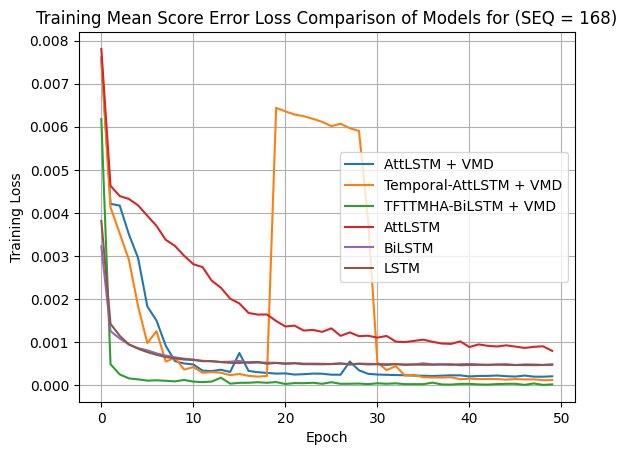

In [75]:
plt.plot(history_attlstm_vmd.history["loss"], label="AttLSTM + VMD")
plt.plot(history_Tattlstm_vmd.history["loss"], label="Temporal-AttLSTM + VMD")
plt.plot(history_TFTattlstm_vmd.history["loss"], label="TFTTMHA-BiLSTM + VMD")
plt.plot(history_attlstm_simple.history["loss"], label="AttLSTM")
plt.plot(history_Bidirectional_lstm_simple.history["loss"], label="BiLSTM")
plt.plot(history_lstm_vmd.history["loss"], label="LSTM")
#plt.plot(history_model_performer_lstm.history["loss"], label="Performer-LSTM")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(f'Training Mean Score Error Loss Comparison of Models for (SEQ = {SEQ_LEN})')
plt.legend()
plt.grid(True)
# ✅ Save figure (300 DPI, PNG)
plt.savefig(
    f'training_loss_comparison_{SEQ_LEN}.png',
    dpi=300,
    bbox_inches="tight"
)

plt.show()
